In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
import gc

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
%%time

print('Loading data...')

train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_identity!')

train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded train_transaction!')

test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_identity!')

test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')
print('\tSuccessfully loaded test_transaction!')

sub = pd.read_csv('sample_submission.csv')
print('\tSuccessfully loaded sample_submission!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train_identity!
	Successfully loaded train_transaction!
	Successfully loaded test_identity!
	Successfully loaded test_transaction!
	Successfully loaded sample_submission!
Data was successfully loaded!

Wall time: 39.7 s


In [4]:
def id_split(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]
    
    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].astype(str).apply(lambda x: x.split(' ')[-1])

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].astype(str).apply(lambda x: x.split(' ')[-1])

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]

    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [5]:
train_identity = id_split(train_identity)
test_identity = id_split(test_identity)

In [6]:
print('Merging data...')
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left', left_index=True)
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left', left_index=True)

print('Data was successfully merged!\n')

del train_identity, train_transaction, test_identity, test_transaction

print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.\n')

gc.collect()

Merging data...
Data was successfully merged!

Train dataset has 590540 rows and 442 columns.
Test dataset has 506691 rows and 441 columns.



0

In [7]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'had_id']

In [8]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionDT')

In [9]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [10]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

In [11]:
# New feature - log of transaction amount. ()
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

# Encoding - count encoding for both train and test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [12]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [13]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [14]:
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([train[[col]], test[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)

    train[col] = np.where(train[col].isin(valid_card), train[col], np.nan)
    test[col]  = np.where(test[col].isin(valid_card), test[col], np.nan)

In [15]:
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train, test]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [16]:
for col in ['ProductCD','M4']:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean'] = test[col].map(temp_dict)

In [17]:
# train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)
# test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)

# train['uid2'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card5'].astype(str)
# test['uid2'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card5'].astype(str)

# train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
# test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

# train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
# test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

# i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

# for col in i_cols:
#     for agg_type in ['mean','std']:
#         new_col_name = col+'_TransactionAmt_'+agg_type
#         temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
#         temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
#                                                 columns={agg_type: new_col_name})
        
#         temp_df.index = list(temp_df[col])
#         temp_df = temp_df[new_col_name].to_dict()   
    
#         train[new_col_name] = train[col].map(temp_df)
#         test[new_col_name]  = test[col].map(temp_df)
           
# # train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
# # test['TransactionAmt'] = np.log1p(test['TransactionAmt'])  

In [18]:
from scripts import frequency_encoding

train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

train['uid4'] = train['uid3'].astype(str)+'_'+train['P_emaildomain'].astype(str)
test['uid4'] = test['uid3'].astype(str)+'_'+test['P_emaildomain'].astype(str)

train['uid5'] = train['uid3'].astype(str)+'_'+train['R_emaildomain'].astype(str)
test['uid5'] = test['uid3'].astype(str)+'_'+test['R_emaildomain'].astype(str)

# Add values remove list
new_columns = ['uid','uid2','uid3','uid4','uid5']
# remove_features += new_columns

# Do Global frequency encoding 
i_cols = ['card1','card2','card3','card5'] + new_columns
train, test = frequency_encoding(train, test, i_cols, self_encoding=False)

In [19]:
for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

In [20]:
train['D9'] = np.where(train['D9'].isna(),0,1)
test['D9'] = np.where(test['D9'].isna(),0,1)

In [21]:
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [22]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

In [23]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

In [24]:
i_cols = [
          'C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D8',
          'addr1','addr2',
          'dist1',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)

In [25]:
noisy_cols = [
    'uid','uid2','uid3','uid4','uid5',
    'id_30','id_31','id_33',
]
# noisy_cols += remove_features

In [26]:
train = train.drop(noisy_cols, axis=1)
test = test.drop(noisy_cols, axis=1)

In [27]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt']) 

In [28]:
cat_le = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']

In [29]:
train.loc[train["card6"]=="debit or credit",'card6']=np.nan
train.loc[train["card6"]=="charge card",'card6']=np.nan
test.loc[test["card6"]=="charge card",'card6']=np.nan

In [30]:
train.loc[train["OS_id_30"]=="other",'OS_id_30']=np.nan
train.loc[train["OS_id_30"]=="func",'OS_id_30']=np.nan
test.loc[test["OS_id_30"]=="other",'OS_id_30']=np.nan
test.loc[test["OS_id_30"]=="func",'OS_id_30']=np.nan

In [31]:
# OS_id_30, 'P_emaildomain_bin', 'R_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_suffix'

In [32]:
cats = ['ProductCD', 'card4', 'card6', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
        'id_12', 'id_15', 'id_37', 'id_38', 'DeviceType', 'OS_id_30', 'P_emaildomain_bin', 
        'R_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_suffix']

In [33]:
# cat_df = pd.concat([train[cats], test[cats]])
# cat_df = pd.get_dummies(cat_df, columns=cats)

# train_cat = cat_df[:590540]
# test_cat = cat_df[590540:]

# del cat_df

# train = train.drop(cats, axis=1)
# test = test.drop(cats, axis=1)

# train = pd.concat([train, train_cat], axis=1)
# test = pd.concat([test, test_cat], axis=1)

# del train_cat, test_cat

In [34]:
%%time

for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))
        print(col)

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_36
id_37
id_38
DeviceType
DeviceInfo
device_name
device_version
OS_id_30
version_id_30
browser_id_31
version_id_31
P_emaildomain_bin
P_emaildomain_suffix
R_emaildomain_bin
R_emaildomain_suffix
Wall time: 47.6 s


In [35]:
# %%time

# for col in cat_le:
#     le = LabelEncoder()
#     le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#     train[col] = le.transform(list(train[col].astype(str).values))
#     test[col] = le.transform(list(test[col].astype(str).values))
#     print(col)

In [36]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1786.14 MB
Memory usage after optimization is: 532.50 MB
Decreased by 70.2%
Memory usage of dataframe is 1511.51 MB
Memory usage after optimization is: 446.98 MB
Decreased by 70.4%
Wall time: 4min 49s


In [37]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

X_test = test.drop(['TransactionDT'], axis=1)

del train, test
gc.collect()

0

In [38]:
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
import itertools
from scipy import interp
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve

warnings.filterwarnings("ignore")

In [39]:
def LGB_bayesian(
    learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    
    columns = X.columns
    train_index = range(int(len(X)*0.7))
    valid_index = range(int(len(X)*0.7), len(X))
    
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': -1,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(X))

    clf = lgb.train(param, dtrain,  num_boost_round=1000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds = 50)
    
    oof[valid_index]  = clf.predict(X_valid, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(y_valid, oof[valid_index])

    return score

In [40]:
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'learning_rate': (0.001, 0.1),
    'min_child_weight': (0.00001, 0.1),   
    'reg_alpha': (0, 1), 
    'reg_lambda': (0, 1),
}

In [41]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [42]:
init_points = 10
n_iter = 15

In [43]:
params = {'num_leaves': 493,
          'min_child_weight': 0.08022167610559643,
          'feature_fraction': 0.5341568665265988,
          'bagging_fraction': 0.32474760774990463,
          'min_data_in_leaf': 33,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.014951498272501501,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.7722447692966574,
          'reg_lambda': 0.1987156815341724,
          'random_state': 47,
          'device' : 'cpu',
         }

In [44]:
X.shape #455 #625

(590540, 389)

In [45]:
%%time

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.989427	valid_1's auc: 0.907516
[400]	training's auc: 0.998874	valid_1's auc: 0.9161
[600]	training's auc: 0.999895	valid_1's auc: 0.91846
[800]	training's auc: 0.999992	valid_1's auc: 0.919369
[1000]	training's auc: 1	valid_1's auc: 0.91948
Early stopping, best iteration is:
[822]	training's auc: 0.999994	valid_1's auc: 0.91955
Fold 1 | AUC: 0.919550094170137
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.989064	valid_1's auc: 0.929741
[400]	training's auc: 0.999186	valid_1's auc: 0.938566
[600]	training's auc: 0.999944	valid_1's auc: 0.940496
[800]	training's auc: 0.999997	valid_1's auc: 0.940767
[1000]	training's auc: 1	valid_1's auc: 0.940688
Early stopping, best iteration is:
[953]	training's auc: 1	valid_1's auc: 0.940918
Fold 2 | AUC: 0.9409183696156315
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.98984	valid_1's 

In [46]:
sub['isFraud'] = y_preds
sub.to_csv("results/lgb_nores_nocat.csv", index=False)

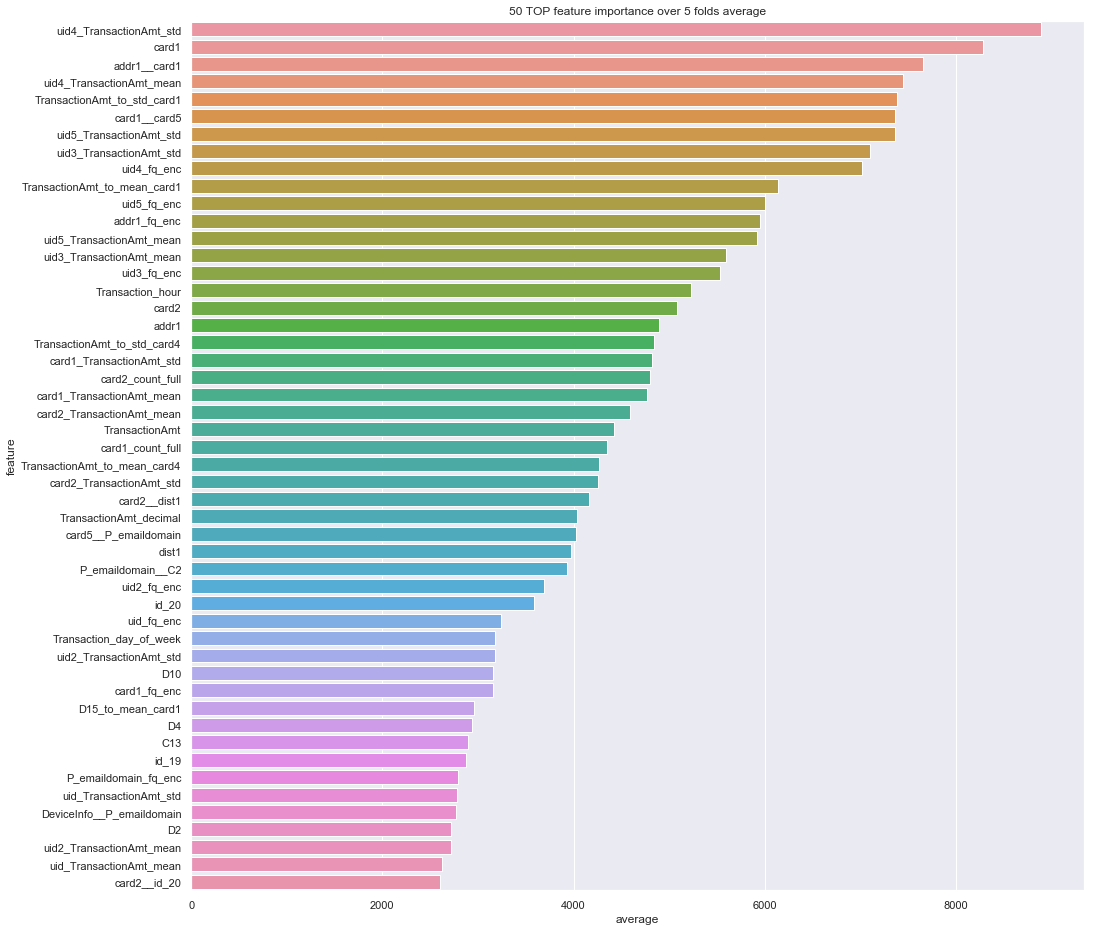

In [47]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));